In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['font.family'] = 'NanumGothic'
import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,DBSCAN
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA

2023-08-24 09:33:12.157632: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 09:33:12.214077: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 09:33:12.215361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 09:33:13.145116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_excel('./수출적재지검사결과.xlsx',engine='openpyxl')

In [3]:
df.head(3)

,수출신고번호,수출신고란번호,품명,거래품명,수출신고규격일련번호,검사일자,검사세관부호,검사과코드,수출검사결과코드,수출검사결과조치코드,검사조치내역
0,4275418500040X,13,OTHER,RECTIFIER,1301,20180126,30,82,M2,Z,케이블 등 추가 신고
1,4275418500040X,14,OTHER,PLASTIC WRAP,1401,20180126,30,82,M2,Z,케이블 등 추가 신고
2,4275418500040X,15,OTHER,WIRE REEL,1501,20180126,30,82,M2,Z,케이블 등 추가 신고


In [4]:
len(df)

102700

In [5]:
ddf = df[df['수출검사결과코드']=='Z'].copy()

In [6]:
ddf['검사조치내역'] = ddf['검사조치내역'].fillna('')
ddf['total_text'] = ddf['검사조치내역']
ddf['total_text'] = ddf['total_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","", regex=True)
ddf['total_text'] = ddf['total_text'].str.replace("ㅇ","", regex=True)

In [7]:
# 결측행 삭제
ddf.dropna(axis=0)

,수출신고번호,수출신고란번호,품명,거래품명,수출신고규격일련번호,검사일자,검사세관부호,검사과코드,수출검사결과코드,수출검사결과조치코드,검사조치내역,total_text
32,4100518010375X,1,SOYBEANS(WITH BLACK TESTA),FROZEN STEAMED BLACK BEAN),101,20180111,30,15,Z,Z,수리후 분석,수리후 분석
39,7001317200103X,1,ROLL,ROLL,101,20180102,20,15,Z,Z,통고처분 및 이행(17.12.27),통고처분 및 이행
40,7001317200103X,1,ROLL,ROLL,102,20180102,20,15,Z,Z,통고처분 및 이행(17.12.27),통고처분 및 이행
41,1190018800010X,1,OTHER,LAENNEC,101,20180105,13,07,Z,Z,"규격,수량단위정정",규격수량단위정정
42,7001317200103X,1,ROLL,ROLL,103,20180102,20,15,Z,Z,통고처분 및 이행(17.12.27),통고처분 및 이행
...,...,...,...,...,...,...,...,...,...,...,...,...
102695,4079123200142X,17,DISODIUM CARBONATE,SODIUM CARBONATE ACS PRIMARY STANDARD,1702,20230615,40,C3,Z,Z,협업검사결과 이상없음,협업검사결과 이상없음
102696,4079123200142X,18,POTASSIUM CARBONATES,POTASSIUM CARBONATE ANHYDROUS,1801,20230615,40,C3,Z,Z,협업검사결과 이상없음,협업검사결과 이상없음
102697,4079123200142X,19,MOLYBDATES,SODIUM MOLYBDENUM OXIDE DIHYDRATE,1901,20230615,40,C3,Z,Z,협업검사결과 이상없음,협업검사결과 이상없음
102698,1048423050290X,2,USED CAR,CARENS,201,20230615,20,C4,Z,Z,2란 운송형태 변경으로 인한 정정,란 운송형태 변경으로 인한 정정


In [8]:
# 폰트 설치 여부 및 경로 확인
# import matplotlib.font_manager as fm
# sys_font = fm.findSystemFonts()
# [f for f in sys_font if 'Nanum' in f]

In [9]:
def wordcloud(grp, model):
    g1 = ddf[ddf[model] == grp].groupby('total_text')['total_text'].count().reset_index(name='cnt')
    
    # 결과를 딕셔너리로 변환
    g1_ditc = {}
    for idx, row in enumerate(g1.iterrows()):
        g1_ditc[row[1]['total_text']] = row[1]['cnt']

    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # 한글 글씨체 설정
        background_color='white', # 배경색은 흰색으로 
        colormap='Reds', # 글씨색은 빨간색으로
        mask=None, # 워드클라우드 모양 설정
        width=800, height=800 # 이미지 크기 설정
    ).generate_from_frequencies(g1_ditc)
    
    # 사이즈 설정 및 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # 차트로 나오지 않게
    plt.title(str(grp) +'번 그룹 WordCloud')
    plt.savefig(str(model)+ '_' + str(grp) +'.png', facecolor='#eeeeee')
    plt.show()

    print('---' * 30)

In [10]:
okt = Okt() # 형태소 분석기 객체 생성
noun_list = []
for content in tqdm.tqdm(ddf['total_text'].fillna('')): 
    nouns = okt.nouns(content) # 명사만 추출하기, 결과값은 명사 리스트
    noun_list.append(nouns)

100%|██████████| 81413/81413 [02:21<00:00, 575.72it/s] 


In [11]:
ddf['nouns'] = noun_list

In [12]:
# Word2Vec 학습
model = Word2Vec(sentences = noun_list, vector_size = 100, window = 5, min_count = 1, workers = 4, sg = 0)

In [13]:
# ddf['nouns']의 값을 하나씩 꺼내서 word2vec 벡터화하고 문장의 단어 벡터를 평균내서 결과를 반환
vectors = ddf['nouns'].apply(lambda x: np.array(np.mean([model.wv[w] for w in x if w in model.wv], axis=0)))

ddf['pad_vectors'] = vectors

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [14]:
# NaN 값을 제거합니다.
ddf = ddf.dropna(subset=['pad_vectors'])

In [15]:
# 비원진 값을 0으로 대입하여 최대크기(100차원) 벡터길이로 모든 자료를 맞춥니다.
max_len = max([len(v) for v in ddf['pad_vectors'] if isinstance(v, np.ndarray)])
pad_vectors = [np.pad(v, (0, max_len - len(v)), 'constant') for v in ddf['pad_vectors'] if isinstance(v, np.ndarray)]
ddf['pad_vectors'] = pad_vectors

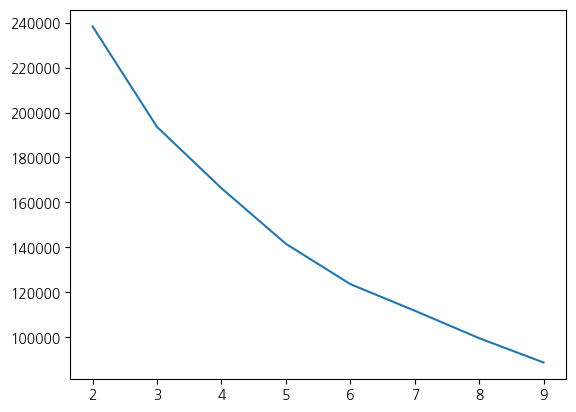

In [16]:
# 군집수 시뮬레이션
itr = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=42, n_init=10)
    km.fit(pad_vectors)
    itr.append(km.inertia_)
    
plt.plot(range(2,10), itr)
plt.show()

In [17]:
# 2차원 배열 형태로 변환합니다.
X = np.array(pad_vectors)
# KMeans 알고리즘을 적용합니다.
kmeans = KMeans(n_clusters=4, random_state=42, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(X)

# 군집 결과를 확인합니다.
labels = kmeans.labels_
ddf['kmeans'] = labels

In [18]:
ddf['kmeans'].value_counts()

2    40914
0    37232
1     2897
3      367
Name: kmeans, dtype: int64

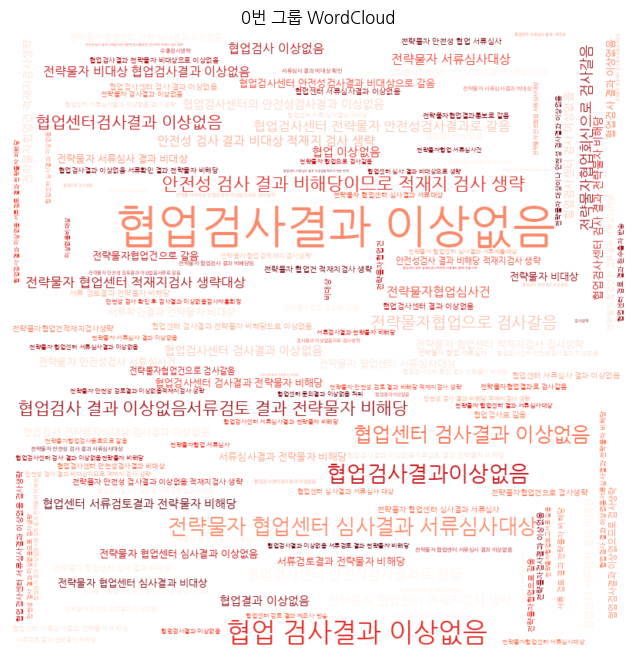

------------------------------------------------------------------------------------------


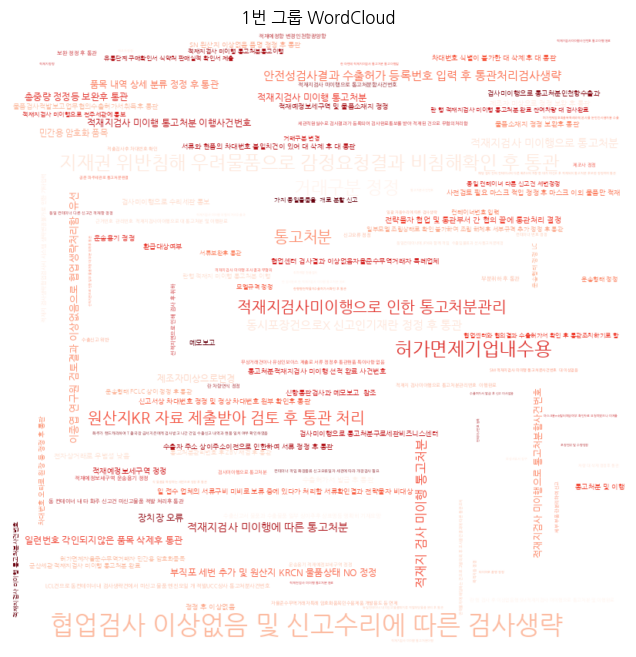

------------------------------------------------------------------------------------------


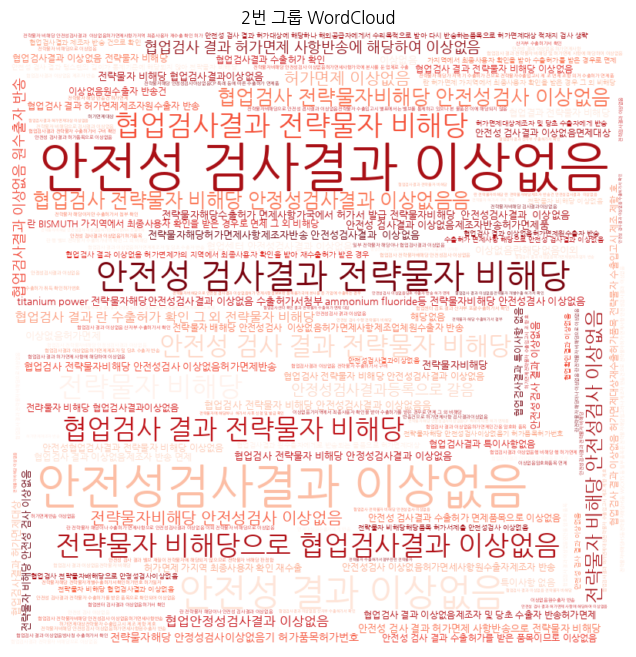

------------------------------------------------------------------------------------------


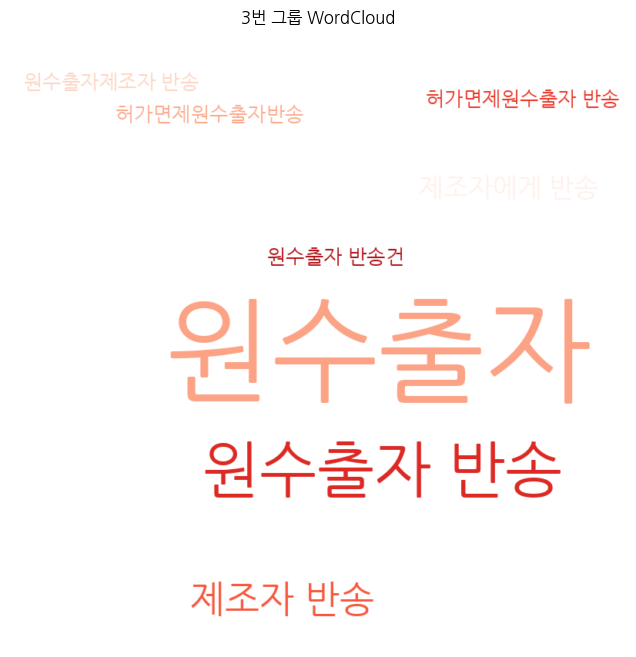

------------------------------------------------------------------------------------------


In [19]:
# 그룹별 워드클라우드 시각화
for i in range(ddf['kmeans'].max()+1):
    wordcloud(i,'kmeans')

In [23]:
# DBSCAN : 인접한 데이터를 클러스터링

X = np.array(pad_vectors) # Normalizer를 이용해 변환된 벡터
# eps 그룹핑할 최대 반경거리
# min_samples 그룹핑한 반경안의 최소 샘플 갯수
model = DBSCAN(eps=1.5,min_samples=250)

# 거리 계산 식으로는 Cosine distance를 이용
model.fit(X)
result = model.fit_predict(X)

In [24]:
ddf['dbscan'] = result

In [25]:
np.unique(ddf['dbscan'])

array([-1,  0,  1,  2,  3,  4,  5,  6])

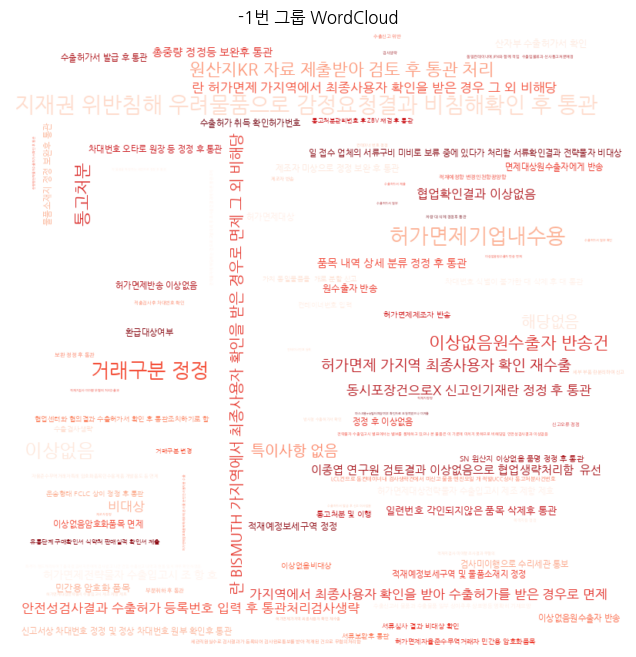

------------------------------------------------------------------------------------------


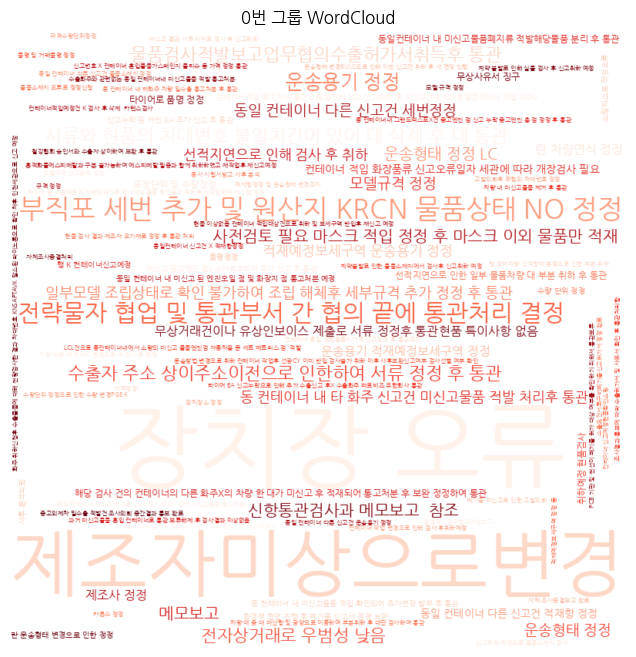

------------------------------------------------------------------------------------------


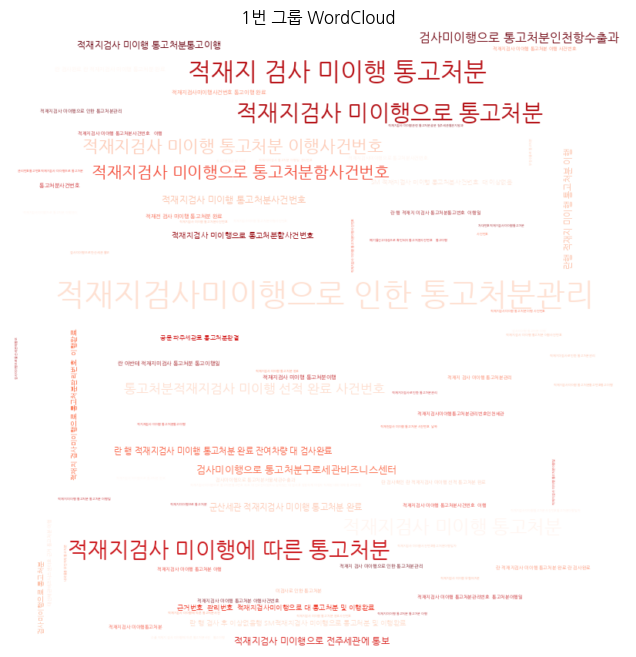

------------------------------------------------------------------------------------------


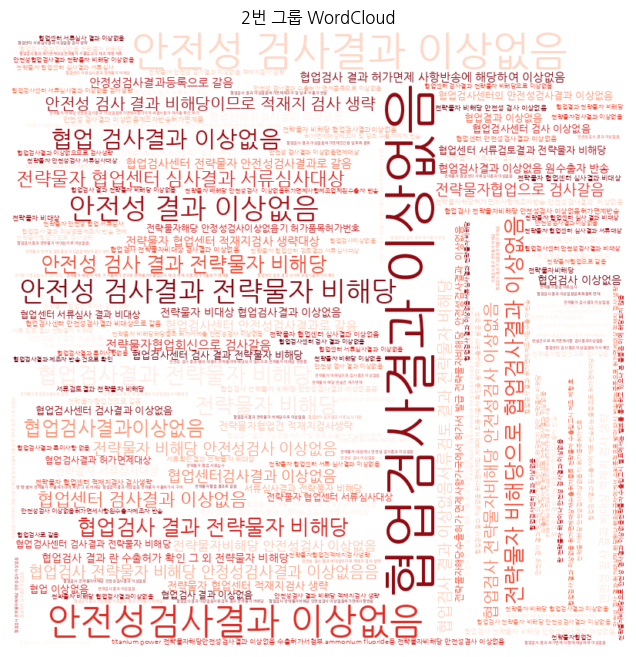

------------------------------------------------------------------------------------------


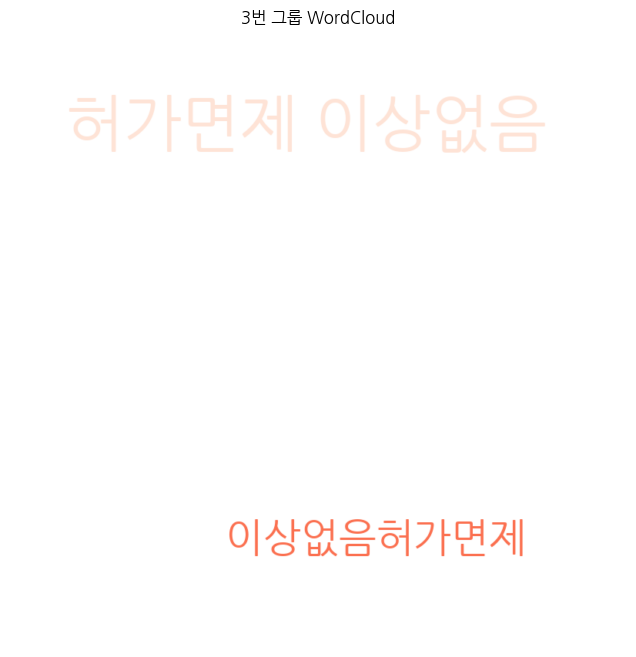

------------------------------------------------------------------------------------------


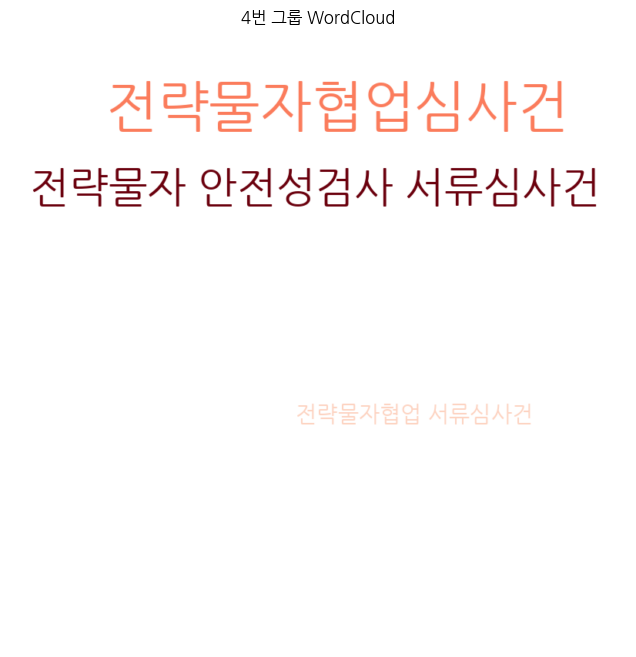

------------------------------------------------------------------------------------------


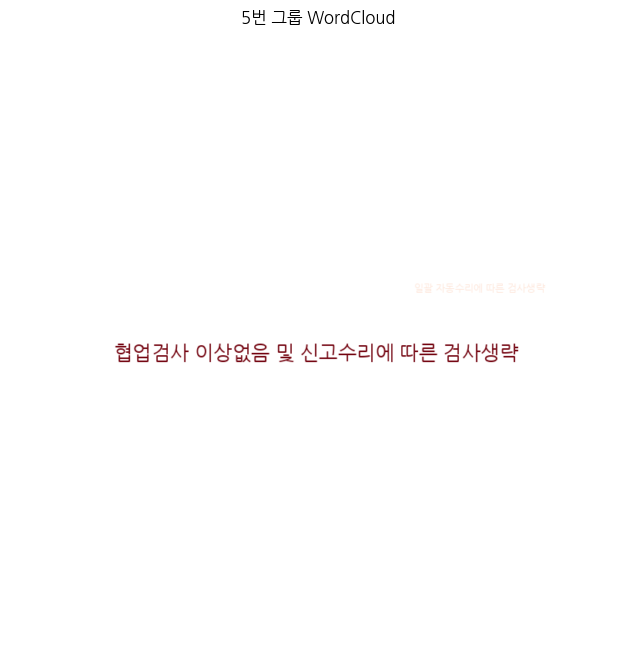

------------------------------------------------------------------------------------------


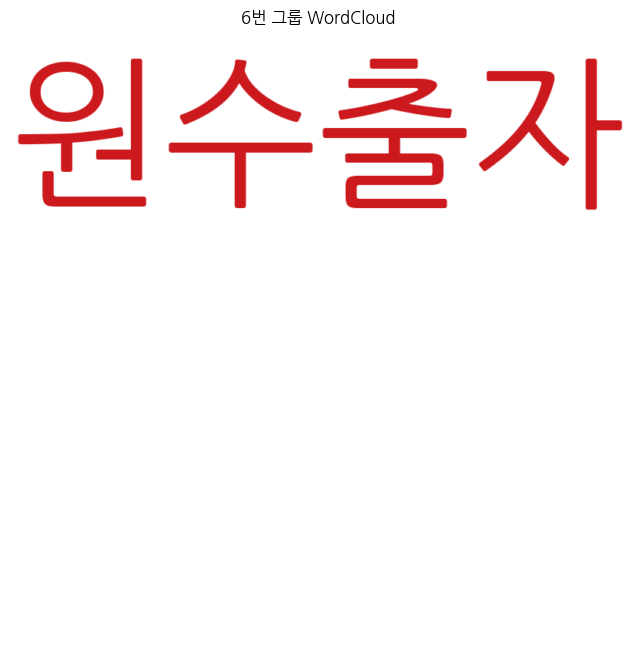

------------------------------------------------------------------------------------------


In [26]:
# 그룹별 워드클라우드 시각화
for i in range(-1, ddf['dbscan'].max()+1):
    wordcloud(i,'dbscan')

In [27]:
ddf.to_excel('./수출적재지검사결과_비지도결과.xlsx',index=False,engine='openpyxl')